# Packages & Libraries

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, auc
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.utils import resample
from sklearn import metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functions import preprocessing_data
import torch
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from joblib import load
from sklearn import metrics
from xgboost.sklearn import XGBClassifier


# Load the labelled network dataset

The Stratosphere Laboratory created a dataset featuring both harmful and harmless IoT network traffic.
They plan to use tools like Wireshark to monitor real-time traffic in different settings. 
By comparing this dataset with Wireshark data, they can train and assess models to detect and prevent potential threats efficiently

In [2]:
# Put the labelled feature/target variable in a variable for further demonstration
labelled_data = pd.read_csv('../RealDataset/Network Datasets/Labelled/Training/Network_Labelled_Dataset.csv')

After specifying the dataset and its features, begun the preprocessing process; a python file (preprocessing_data.py)
 has been taking charge and outputs a cleaned and robust format of the original dataset as much as possible to work as the model input.

In [3]:
train_data, unique_tables = preprocessing_data.preprocess_data(labelled_data)

      timestamp  src_ip  src_port          dest_ip  dest_port  proto  service  \
0  1.525880e+09    6478     51524   65.127.233.163         23      1        0   
1  1.525880e+09    6478     56305    63.150.16.171         23      1        0   
2  1.525880e+09    6478     41101     111.40.23.49         23      1        0   
3  1.525880e+09    6478     60905  131.174.215.147         23      1        0   
4  1.525880e+09    6478     44301      91.42.47.63         23      1        0   

   duration orig_bytes resp_bytes conn_state history  src_pkts  src_ip_bytes  \
0         3          0          0         S0       S         3           180   
1         0         -1         -1         S0       S         1            60   
2         0         -1         -1         S0       S         1            60   
3         3          0          0         S0       S         3           180   
4         0         -1         -1         S0       S         1            60   

   dest_pkts  dest_ip_bytes  lab

In [4]:
# This part of the code calls the to_csv method on the train_data DataFrame.
train_data.to_csv('../RealDataset/Network Datasets/Labelled/Training/Preprocessed_Laballed_Dataset.csv', index=False)

In [5]:
# load CSV file into a DataFrame variable named train_data
train_data = pd.read_csv('../RealDataset/Network Datasets/Labelled/Training/Preprocessed_Laballed_Dataset.csv')

# Specify the features (X) and target variable (y)

Feature Importance Ranking: 
Utilization of techniques such as correlation analysis and feature importance scores to overview their relevance to the target variable.
The selection aimed to enhance model efficacy, diminish dimensionality,  

In [6]:
correlation = train_data.corr()

<Axes: >

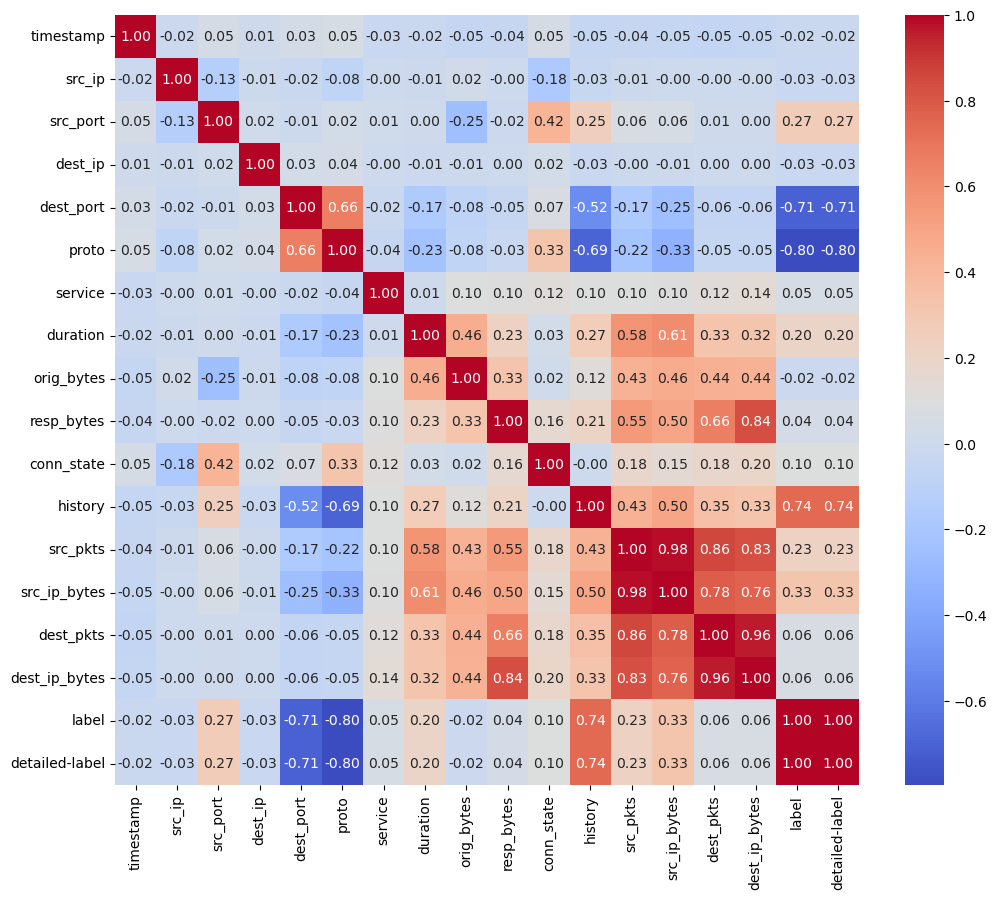

In [7]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, cmap='coolwarm', annot=True, fmt='.2f')

After analyzing the correlation graph we can drop all the features that do not affect the model training

In [8]:
columns_to_drop = ['proto', 'service', 'resp_bytes', 'orig_bytes',
                   'dest_pkts', 'src_pkts', 'src_ip_bytes', 'dest_ip_bytes', 'conn_state']

In [9]:
# Drop all the columns specified in columns_to_drop variable above
train_data= train_data.drop(columns=columns_to_drop)

#This line is selecting the column named 'label' from the DataFrame train_data.
features = list(train_data.columns[:-2])

In [10]:
X = train_data.iloc[:, :-2]
y = train_data['label']

The dataset has been partitioned into three subsets: a training dataset comprising 60% of the total dataset,
and two separate validation and testing datasets, each containing 20% of the total remaining 40% of the entire dataset.

In [11]:
#As one dataset for training, validation, and testing (2 splits)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, shuffle=True, train_size=0.6, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [12]:
# Check the sizes of the training and testing sets
print("Training set size - Features:", X_train.shape, " Target:", y_train.shape)
print("Testing set size - Features:", X_test.shape, " Target:", y_test.shape)
print("Validation set size - Features:", X_val.shape, " Target:", y_val.shape)

Training set size - Features: (605248, 7)  Target: (605248,)
Testing set size - Features: (201750, 7)  Target: (201750,)
Validation set size - Features: (201750, 7)  Target: (201750,)


In [13]:
# All Splits are saved in SplitDatasets folder to use it in ModelTraining for training purposes.
X_train.to_csv('SplitDatasets/features_train.csv', index=False)
y_train.to_csv('SplitDatasets/labels_train.csv', index=False)

X_val.to_csv('SplitDatasets/features_val.csv', index=False)
y_val.to_csv('SplitDatasets/labels_val.csv', index=False)

X_test.to_csv('SplitDatasets/features_test.csv', index=False)
y_test.to_csv('SplitDatasets/labels_test.csv', index=False)

In [14]:
# This line creates a new DataFrame df_train from X_train, which contains the training data features.
df_train = pd.DataFrame(X_train, columns=train_data.columns[:-2])

# This line adds a new column set to df_train and sets all its values to the string 'train'. This is useful for indicating that this portion of the DataFrame contains training data.
df_train['set'] = 'train'

# The target variable is added to the DataFrame
df_train['target'] = y_train

# Similar to the training DataFrame, this line creates a new DataFrame df_val from X_val, using the same columns as the training data minus the last two.
df_val = pd.DataFrame(X_val, columns=train_data.columns[:-2])

# This line assigns the string 'val' to a new column set in df_val, identifying these rows as validation data.
df_val['set'] = 'val'

# This adds a target column to df_val with the values from y_val. The target in this DataFrame will be used for validating the model's predictions.
df_val['target'] = y_val

# Creates a DataFrame df_test from X_test with the same columns as the training and validation DataFrames
df_test = pd.DataFrame(X_test, columns=train_data.columns[:-2])

# This line marks the data in this DataFrame as test data by setting all values in the new set column to 'test'.
df_test['set'] = 'test'

# The target values here are used to test the model's performance.
df_test['target'] = y_test

In [15]:
# Combine all DataFrames into one 
df_combined = pd.concat([df_train, df_val, df_test])

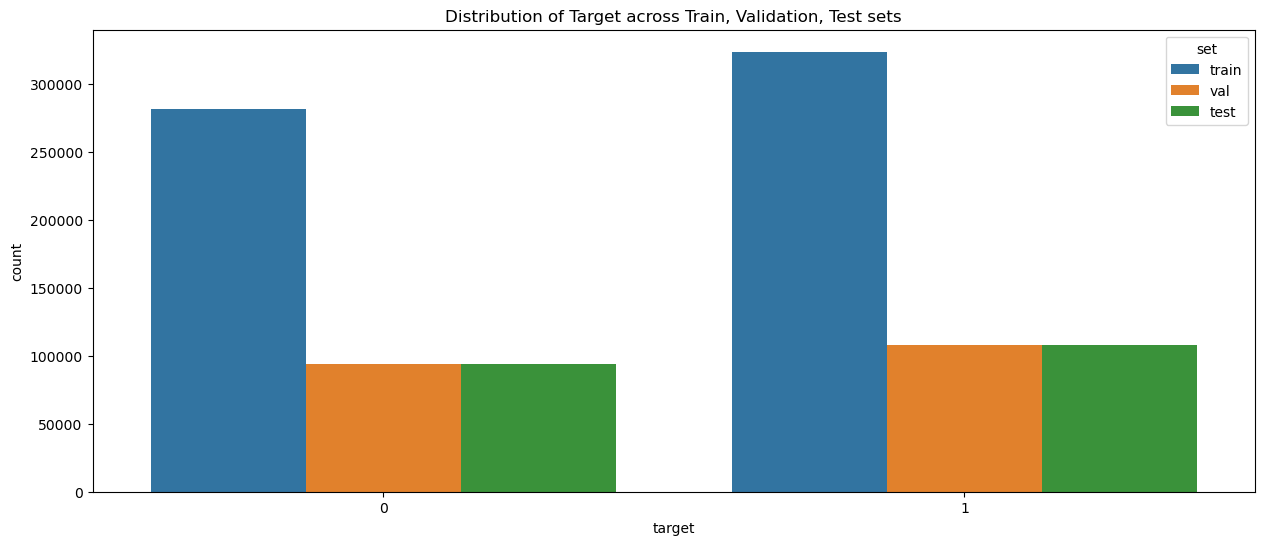

In [16]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df_combined, x='target', hue='set')
plt.title('Distribution of Target across Train, Validation, Test sets')
plt.show()

# Stratify could fix imbalanced val and test splits

The current phase will focus on predicting the models from the training used by modelTraining file which train the models and save them into dump files to avoid re-training which can consume a lot of time.

For the analysis phase, it will be printed out after each model and here some information regarding it:

1- classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
a- classification_report is called with the actual labels y_test and the predicted labels y_pred from a classifier.
b- target_names=['Class 0', 'Class 1'] provides human-readable names for the classes, which are otherwise typically represented as 0 and 1. This makes the report easier to understand.
c- output_dict=True specifies that the output should be a Python dictionary instead of the default text report. This allows for easier subsequent manipulation of the scores in the report.
d- The output, classification_rep, is a dictionary containing precision, recall, and f1-score for each class, among other details like accuracy and a macro-average and weighted-average of these scores across classes.


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix

class ModelEvaluator:
    def __init__(self, y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
        
    
    def evaluate_model(self):
        # Extract values from the confusion matrix
        conf_matrix = confusion_matrix(self.y_test, self.y_pred)
        TP = conf_matrix[1, 1]
        TN = conf_matrix[0, 0]
        FP = conf_matrix[0, 1]
        FN = conf_matrix[1, 0]

        # Calculate accuracy, precision, recall, and F1-score as percentages
        total_samples = len(self.y_test)
        accuracy = ((TP + TN) / total_samples) * 100
        precision = (TP / (TP + FP)) * 100
        recall = (TP / (TP + FN)) * 100
        f1_score = (2 * precision * recall) / (precision + recall)
        sensitivity = (TP / (TP + FN)) * 100
        specificity = (TN / (TN + FP)) * 100
        #Print all evaluation metrics for debugging purposes.
        print("Accuracy:",accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-score:", f1_score)
        print('Sensitivity Rate:', sensitivity)
        print('Specificity Rate:', specificity)
        return accuracy, precision, recall, f1_score, sensitivity, specificity 
    def get_confusion_matrix(self):
        # Return the confusion matrix
        return confusion_matrix(self.y_test, self.y_pred)

# Sample usage

You can run ModelTraining.ipynb Now.

*Note: We didn't make it run automatically due to waiting time. You can check the processed train by yourself from ModelTraining.ipynb file.

# XGBoost classifier implementation

In [18]:
# This model name is used to ease the visualization process. Change it for each model.
model_name = 'XGBoost'

# Load XGBoost model, where it is already trained from 'ModelTraining.ipynb' code file.
xgb_classifier = load('TrainingDumpData/MachineLearning/XGBoost_Model.joblib')

print('Training Accuracy : ',
      metrics.accuracy_score(y_train, 
                             xgb_classifier.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             xgb_classifier.predict(X_val))*100)
# Make predictions on the testing data
y_pred = xgb_classifier.predict(X_test)

# Calculate the accuracy of the model
xgb_accuracy = accuracy_score(y_test, y_pred) * 100
print("Testing Accuracy:", xgb_accuracy)


Training Accuracy :  99.34440097282436
Validation Accuracy :  99.34076827757126
Testing Accuracy: 99.35960346964065


Analysis for XGBoost:

In [19]:
# Important note, for next models, we gotta insert values to these arrays so that they are used to visualize each model evaluation metrics.
model_accuracy =np.array([])
model_precision = np.array([])
model_recall = np.array([])
model_f1_score = np.array([])
model_specificity = np.array([])
model_sensitivity = np.array([])

In [20]:
model_evaluator = ModelEvaluator(y_test, y_pred)
accuracy, precision, recall, f1_score, sensitivity ,specificity = model_evaluator.evaluate_model()
conf_matrix = model_evaluator.get_confusion_matrix()

# Append results to lists
model_accuracy = np.append(model_accuracy, accuracy) 
model_precision = np.append(model_precision, precision)
model_recall = np.append(model_recall, recall)
model_f1_score = np.append(model_f1_score, f1_score)
model_specificity = np.append(model_specificity, specificity)
model_sensitivity = np.append(model_sensitivity, sensitivity)


Accuracy: 99.35960346964065
Precision: 98.82296904912387
Recall: 99.99351221094582
F1-score: 99.4047948108427
Sensitivity Rate: 99.99351221094582
Specificity Rate: 98.63086676255926


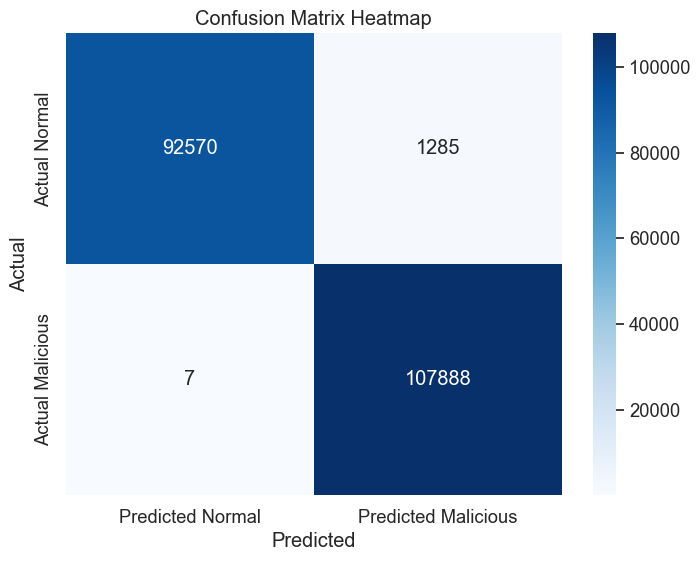

In [21]:
# Define labels for confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
xgb_conf_matrix = conf_matrix
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Malicious'], yticklabels=['Actual Normal', 'Actual Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

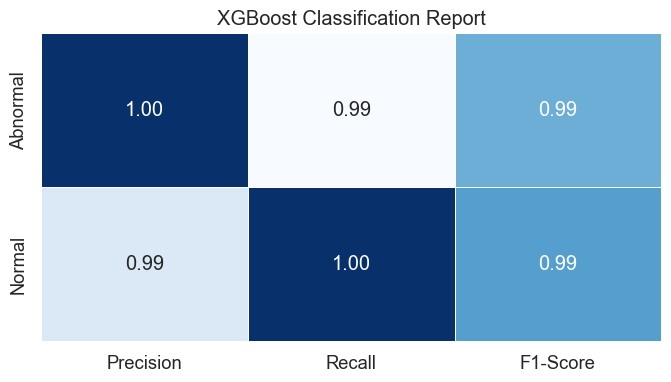

In [22]:
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

precision_rep = [classification_rep['Class 0']['precision'], classification_rep['Class 1']['precision']]
recall_rep = [classification_rep['Class 0']['recall'], classification_rep['Class 1']['recall']]
f1_score_rep = [classification_rep['Class 0']['f1-score'], classification_rep['Class 1']['f1-score']]

report_data = {
    'Precision': precision_rep,
    'Recall': recall_rep,
    'F1-Score': f1_score_rep,
}

class_names = ['Abnormal', 'Normal']

report_df = pd.DataFrame(report_data, index=class_names)

# Plot the classification report
plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap='Blues', cbar=False, linewidths=0.5)
plt.title(f'{model_name} Classification Report')
plt.show()

In [23]:
"""
# Define range of training set sizes for learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Create learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator= xgb_classifier, X=X, y=y, train_sizes=train_sizes, cv=5)

# Calculate mean and standard deviation of training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.grid()
plt.show()
"""

"\n# Define range of training set sizes for learning curve\ntrain_sizes = np.linspace(0.1, 1.0, 10)\n\n# Create learning curve\ntrain_sizes, train_scores, test_scores = learning_curve(\n    estimator= xgb_classifier, X=X, y=y, train_sizes=train_sizes, cv=5)\n\n# Calculate mean and standard deviation of training and testing scores\ntrain_mean = np.mean(train_scores, axis=1)\ntrain_std = np.std(train_scores, axis=1)\ntest_mean = np.mean(test_scores, axis=1)\ntest_std = np.std(test_scores, axis=1)\n\n# Plot learning curve\nplt.figure(figsize=(10, 6))\nplt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')\nplt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')\nplt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')\nplt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')\nplt.xlabel('Numb

# Logistic Regression implementation

In [24]:
# This model name is used to ease the visualization process. Change it for each model.
model_name = 'Logistic Regression'

# Load Logisitc Regression Classifier Model, where it is already trained from 'ModelTraining.ipynb' code file.
logreg_classifier = load('TrainingDumpData/MachineLearning/LogReg_Model.joblib')

print('Training Accuracy : ',
      metrics.accuracy_score(y_train, 
                             logreg_classifier.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             logreg_classifier.predict(X_val))*100)

# Make predictions
y_pred = logreg_classifier.predict(X_test)

# Calculate accuracy
Lr_accuracy = metrics.accuracy_score(y_test, y_pred)*100
print("Testing Accuracy:", Lr_accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Training Accuracy :  53.47940017976103
Validation Accuracy :  53.479553903345725
Testing Accuracy: 53.479553903345725

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     93855
           1       0.53      1.00      0.70    107895

    accuracy                           0.53    201750
   macro avg       0.27      0.50      0.35    201750
weighted avg       0.29      0.53      0.37    201750



In [25]:
model_evaluator = ModelEvaluator(y_test, y_pred)
accuracy, precision, recall, f1_score, sensitivity ,specificity = model_evaluator.evaluate_model()
conf_matrix = model_evaluator.get_confusion_matrix()

# Append results to lists
model_accuracy = np.append(model_accuracy, accuracy) 
model_precision = np.append(model_precision, precision)
model_recall = np.append(model_recall, recall)
model_f1_score = np.append(model_f1_score, f1_score)
model_specificity = np.append(model_specificity, specificity)
model_sensitivity = np.append(model_sensitivity, sensitivity)

Accuracy: 53.479553903345725
Precision: 53.479553903345725
Recall: 100.0
F1-score: 69.68948311776388
Sensitivity Rate: 100.0
Specificity Rate: 0.0


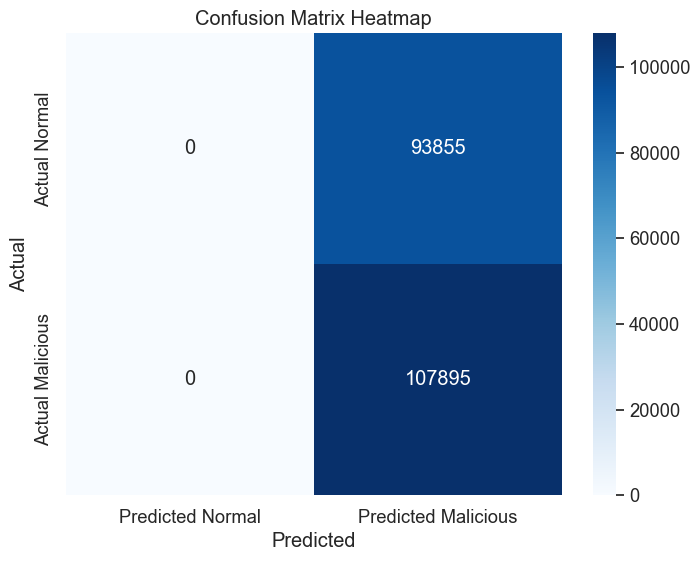

In [26]:
# Define labels for confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
logreg_conf_matrix = conf_matrix
sns.heatmap(logreg_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Malicious'], yticklabels=['Actual Normal', 'Actual Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

c:\Users\ninja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ninja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ninja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


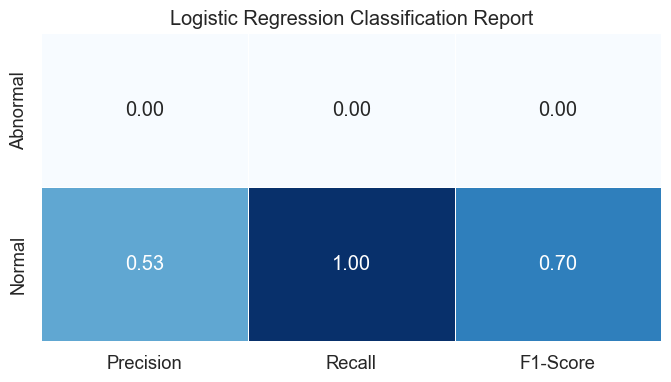

In [27]:
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

precision_rep = [classification_rep['Class 0']['precision'], classification_rep['Class 1']['precision']]
recall_rep = [classification_rep['Class 0']['recall'], classification_rep['Class 1']['recall']]
f1_score_rep = [classification_rep['Class 0']['f1-score'], classification_rep['Class 1']['f1-score']]

report_data = {
    'Precision': precision_rep,
    'Recall': recall_rep,
    'F1-Score': f1_score_rep,
}

class_names = ['Abnormal', 'Normal']

report_df = pd.DataFrame(report_data, index=class_names)

# Plot the classification report
plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap='Blues', cbar=False, linewidths=0.5)
plt.title(f'{model_name} Classification Report')
plt.show()

In [28]:
"""
# Define range of training set sizes for learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Create learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator= logreg_classifier, X=X, y=y, train_sizes=train_sizes, cv=5)

# Calculate mean and standard deviation of training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.grid()
plt.show()
"""

"\n# Define range of training set sizes for learning curve\ntrain_sizes = np.linspace(0.1, 1.0, 10)\n\n# Create learning curve\ntrain_sizes, train_scores, test_scores = learning_curve(\n    estimator= logreg_classifier, X=X, y=y, train_sizes=train_sizes, cv=5)\n\n# Calculate mean and standard deviation of training and testing scores\ntrain_mean = np.mean(train_scores, axis=1)\ntrain_std = np.std(train_scores, axis=1)\ntest_mean = np.mean(test_scores, axis=1)\ntest_std = np.std(test_scores, axis=1)\n\n# Plot learning curve\nplt.figure(figsize=(10, 6))\nplt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')\nplt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')\nplt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')\nplt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')\nplt.xlabel('N

# K-Nearest Classifier implementation

In [29]:
# This model name is used to ease the visualization process. Change it for each model.
model_name = 'K-Nearest'

# Load K-Nearest Classifier Model, where it is already trained from 'ModelTraining.ipynb' code file.
knn_classifier = load('TrainingDumpData/MachineLearning/Knn_Model.joblib')

print('Training Accuracy : ',
      metrics.accuracy_score(y_train, 
                             knn_classifier.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             knn_classifier.predict(X_val))*100)

# Predict on the test data
y_pred = knn_classifier.predict(X_test)

# Calculate accuracy
Knn_accuracy = metrics.accuracy_score(y_test, y_pred)*100
print("Testing Accuracy:", Knn_accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Training Accuracy :  96.84393835254309
Validation Accuracy :  94.69789343246592
Testing Accuracy: 94.7003717472119

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     93855
           1       0.94      0.97      0.95    107895

    accuracy                           0.95    201750
   macro avg       0.95      0.95      0.95    201750
weighted avg       0.95      0.95      0.95    201750



In [30]:
model_evaluator = ModelEvaluator(y_test, y_pred)
accuracy, precision, recall, f1_score, sensitivity ,specificity = model_evaluator.evaluate_model()
conf_matrix = model_evaluator.get_confusion_matrix()

# Append results to lists
# Append results to lists
model_accuracy = np.append(model_accuracy, accuracy) 
model_precision = np.append(model_precision, precision)
model_recall = np.append(model_recall, recall)
model_f1_score = np.append(model_f1_score, f1_score)
model_specificity = np.append(model_specificity, specificity)
model_sensitivity = np.append(model_sensitivity, sensitivity)

Accuracy: 94.7003717472119
Precision: 93.51035353309281
Recall: 96.8089346123546
F1-score: 95.13105885353103
Sensitivity Rate: 96.8089346123546
Specificity Rate: 92.27638378349582


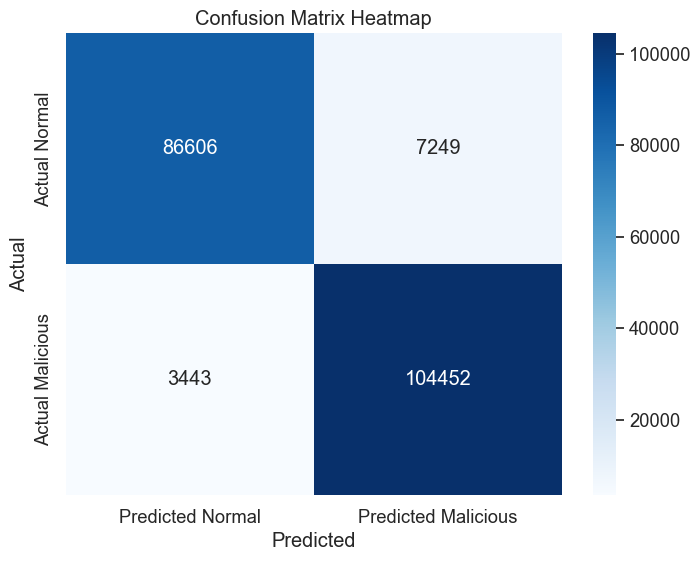

In [31]:
# Define labels for confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
knn_conf_matrix = conf_matrix
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Malicious'], yticklabels=['Actual Normal', 'Actual Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

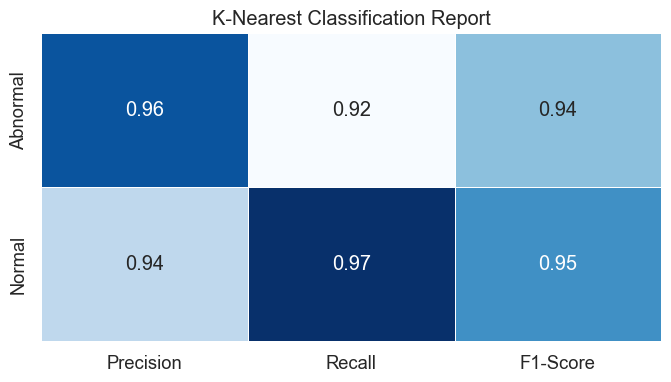

In [32]:
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

precision_rep = [classification_rep['Class 0']['precision'], classification_rep['Class 1']['precision']]
recall_rep = [classification_rep['Class 0']['recall'], classification_rep['Class 1']['recall']]
f1_score_rep = [classification_rep['Class 0']['f1-score'], classification_rep['Class 1']['f1-score']]

report_data = {
    'Precision': precision_rep,
    'Recall': recall_rep,
    'F1-Score': f1_score_rep,
}

class_names = ['Abnormal', 'Normal']

report_df = pd.DataFrame(report_data, index=class_names)

# Plot the classification report
plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap='Blues', cbar=False, linewidths=0.5)
plt.title(f'{model_name} Classification Report')
plt.show()

# Random Forest Classifier implementation

In [33]:
# This model name is used to ease the visualization process. Change it for each model.
model_name = 'Random Forest'

# Load Random Forest Classifier Model, where it is already trained from 'ModelTraining.ipynb' code file.
rf_classifier = load('TrainingDumpData/MachineLearning/RF_Model.joblib')

print('Training Accuracy : ',
      metrics.accuracy_score(y_train, 
                             rf_classifier.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             rf_classifier.predict(X_val))*100)
# Predict on the test data
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
Rf_accuracy = metrics.accuracy_score(y_test, y_pred)*100
print("Testing Accuracy:", Rf_accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Accuracy :  100.0
Validation Accuracy :  99.98513011152417
Testing Accuracy: 99.98859975216853

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93855
           1       1.00      1.00      1.00    107895

    accuracy                           1.00    201750
   macro avg       1.00      1.00      1.00    201750
weighted avg       1.00      1.00      1.00    201750



In [34]:
model_evaluator = ModelEvaluator(y_test, y_pred)
accuracy, precision, recall, f1_score, sensitivity ,specificity = model_evaluator.evaluate_model()
conf_matrix = model_evaluator.get_confusion_matrix()

# Append results to lists
model_accuracy = np.append(model_accuracy, accuracy) 
model_precision = np.append(model_precision, precision)
model_recall = np.append(model_recall, recall)
model_f1_score = np.append(model_f1_score, f1_score)
model_specificity = np.append(model_specificity, specificity)
model_sensitivity = np.append(model_sensitivity, sensitivity)

Accuracy: 99.98859975216853
Precision: 99.98517200474495
Recall: 99.99351221094582
F1-score: 99.98934193392925
Sensitivity Rate: 99.99351221094582
Specificity Rate: 99.98295242661553


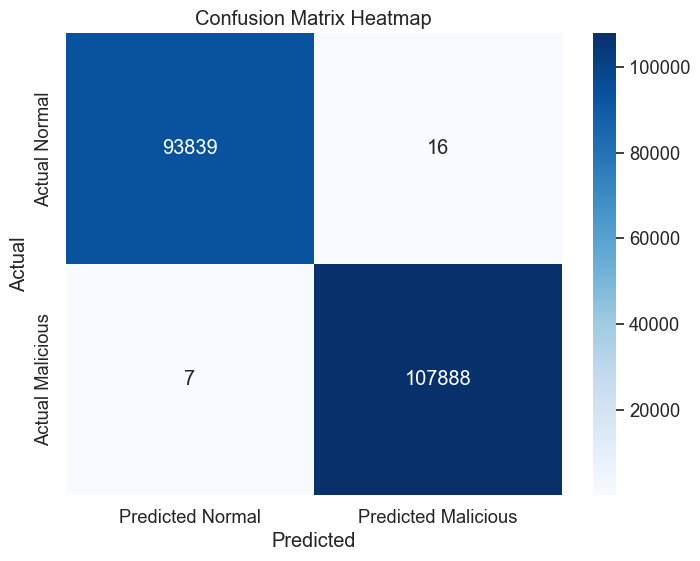

In [35]:
# Define labels for confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
rf_conf_matrix = conf_matrix
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Malicious'], yticklabels=['Actual Normal', 'Actual Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

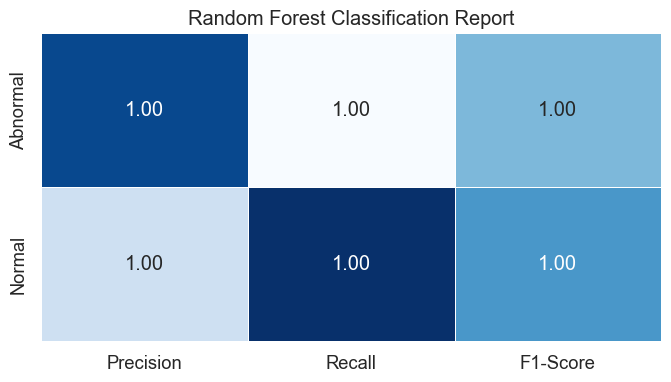

In [36]:
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

precision_rep = [classification_rep['Class 0']['precision'], classification_rep['Class 1']['precision']]
recall_rep = [classification_rep['Class 0']['recall'], classification_rep['Class 1']['recall']]
f1_score_rep = [classification_rep['Class 0']['f1-score'], classification_rep['Class 1']['f1-score']]

report_data = {
    'Precision': precision_rep,
    'Recall': recall_rep,
    'F1-Score': f1_score_rep,
}

class_names = ['Abnormal', 'Normal']

report_df = pd.DataFrame(report_data, index=class_names)

# Plot the classification report
plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap='Blues', cbar=False, linewidths=0.5)
plt.title(f'{model_name} Classification Report')
plt.show()

# Gaussian Naive Bayes Classifier implementation

In [37]:
# This model name is used to ease the visualization process. Change it for each model.
model_name = 'Gaussian Naive Bayes'

# Load Gaussian Naive Bayes Classifier Model, where it is already trained from 'ModelTraining.ipynb' code file.
gnb = load('TrainingDumpData/MachineLearning/GNBayes_Model.joblib')

print('Training Accuracy : ',
      metrics.accuracy_score(y_train, 
                             gnb.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             gnb.predict(X_val))*100)

# Predict on the test data
y_pred = gnb.predict(X_test)

# Calculate accuracy
Gnb_accuracy = metrics.accuracy_score(y_test, y_pred)*100
print("Testing Accuracy:", Gnb_accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Accuracy :  89.19599899545311
Validation Accuracy :  89.1910780669145
Testing Accuracy: 89.2629491945477

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     93855
           1       0.83      1.00      0.91    107895

    accuracy                           0.89    201750
   macro avg       0.92      0.88      0.89    201750
weighted avg       0.91      0.89      0.89    201750



In [38]:
model_evaluator = ModelEvaluator(y_test, y_pred)
accuracy, precision, recall, f1_score, sensitivity ,specificity = model_evaluator.evaluate_model()
conf_matrix = model_evaluator.get_confusion_matrix()

# Append results to lists
model_accuracy = np.append(model_accuracy, accuracy) 
model_precision = np.append(model_precision, precision)
model_recall = np.append(model_recall, recall)
model_f1_score = np.append(model_f1_score, f1_score)
model_specificity = np.append(model_specificity, specificity)
model_sensitivity = np.append(model_sensitivity, sensitivity)

Accuracy: 89.2629491945477
Precision: 83.27994627847202
Recall: 100.0
F1-score: 90.8773141519128
Sensitivity Rate: 100.0
Specificity Rate: 76.91971658409248


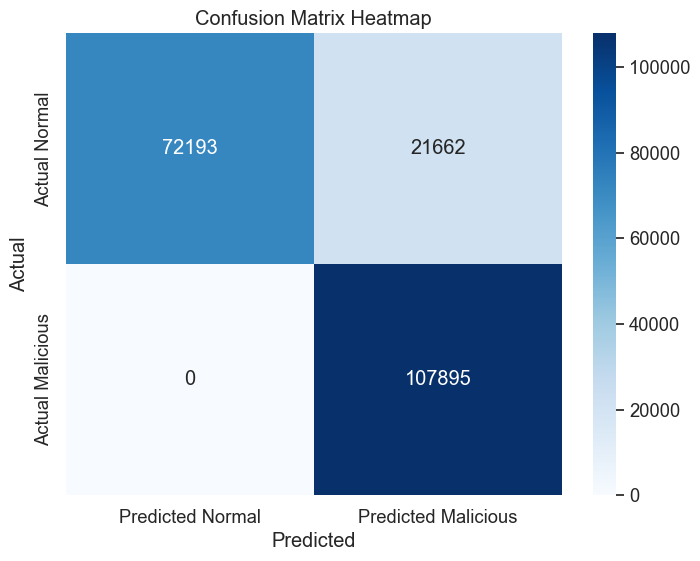

In [39]:
# Define labels for confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
gnb_conf_matrix = conf_matrix
sns.heatmap(gnb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Malicious'], yticklabels=['Actual Normal', 'Actual Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

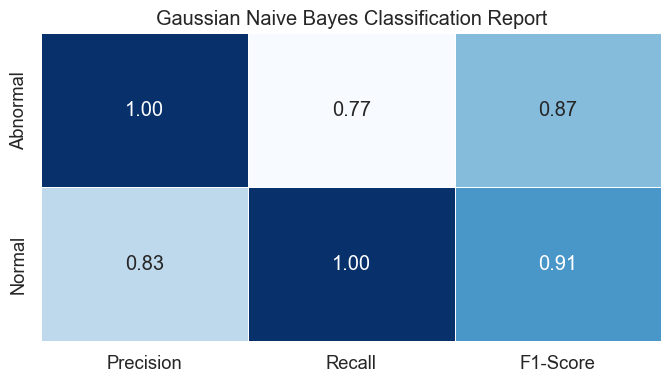

In [40]:
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

precision_rep = [classification_rep['Class 0']['precision'], classification_rep['Class 1']['precision']]
recall_rep = [classification_rep['Class 0']['recall'], classification_rep['Class 1']['recall']]
f1_score_rep = [classification_rep['Class 0']['f1-score'], classification_rep['Class 1']['f1-score']]

report_data = {
    'Precision': precision_rep,
    'Recall': recall_rep,
    'F1-Score': f1_score_rep,
}

class_names = ['Abnormal', 'Normal']

report_df = pd.DataFrame(report_data, index=class_names)

# Plot the classification report
plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap='Blues', cbar=False, linewidths=0.5)
plt.title(f'{model_name} Classification Report')
plt.show()

# Decision Tree Classifier implementation

In [41]:
d_max = range(2,20,1)
lf_max = [3,5,4,2,11,6,8,9]
result = []
train_acc = []
val_acc = []

for d in d_max:
    clf = tree.DecisionTreeClassifier(criterion='gini', splitter="random", max_leaf_nodes=6, min_samples_leaf=2, max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    
    y_val_pred = clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc.append({
        val_accuracy})
    
    y_train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc.append({
        train_accuracy})
    
    result.append({
        'Max-depth': d,
        'Validation_Accuracy': val_accuracy,
        'Train_Accuracy': train_accuracy
    })

In [42]:
df_result = pd.DataFrame(result)
df_result = df_result.sort_values(by='Validation_Accuracy', ascending=False)

In [43]:
df_result

,Max-depth,Validation_Accuracy,Train_Accuracy
2,4,0.987138,0.987413
9,11,0.987133,0.987407
10,12,0.987133,0.987407
16,18,0.987133,0.987407
15,17,0.987133,0.987407
14,16,0.987133,0.987407
13,15,0.987133,0.987407
12,14,0.987133,0.987407
11,13,0.987133,0.987407
17,19,0.987133,0.987407


In [44]:
# This model name is used to ease the visualization process. Change it for each model.
model_name = 'Decision Tree'

# Load Decision Tree Classifier Model, where it is already trained from 'ModelTraining.ipynb' code file.
dt_classifier = load('TrainingDumpData/MachineLearning/DT_Model.joblib')

print('Training Accuracy : ',
      metrics.accuracy_score(y_train, 
                             dt_classifier.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             dt_classifier.predict(X_val))*100)

y_pred = dt_classifier.predict(X_test)
Dt_accuracy = accuracy_score(y_test, y_pred)*100
print("Testing Accuracy: ", Dt_accuracy)

Training Accuracy :  99.90565850692609
Validation Accuracy :  99.91127633209418
Testing Accuracy:  99.90532837670384


In [45]:
model_evaluator = ModelEvaluator(y_test, y_pred)
accuracy, precision, recall, f1_score, sensitivity ,specificity = model_evaluator.evaluate_model()
conf_matrix = model_evaluator.get_confusion_matrix()

# Append results to lists
model_accuracy = np.append(model_accuracy, accuracy) 
model_precision = np.append(model_precision, precision)
model_recall = np.append(model_recall, recall)
model_f1_score = np.append(model_f1_score, f1_score)
model_specificity = np.append(model_specificity, specificity)
model_sensitivity = np.append(model_sensitivity, sensitivity)

Accuracy: 99.90532837670384
Precision: 99.83158751896953
Recall: 99.99165855693035
F1-score: 99.91155892444539
Sensitivity Rate: 99.99165855693035
Specificity Rate: 99.80608385275158


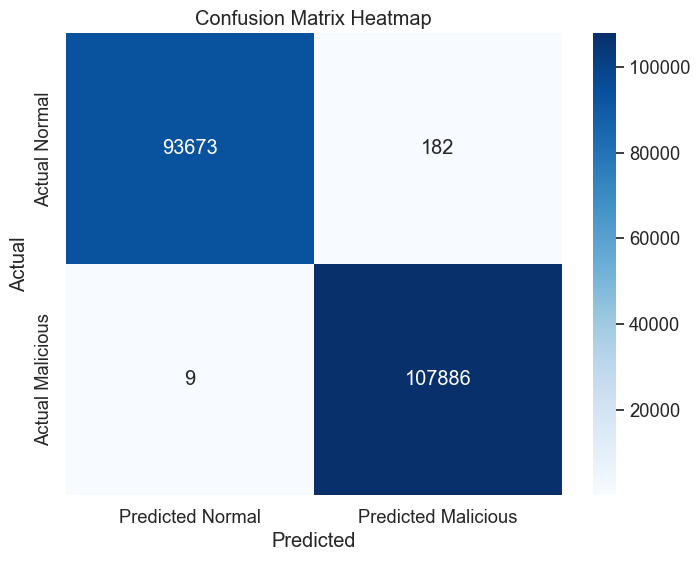

In [46]:
# Define labels for confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
dt_conf_matrix = conf_matrix
sns.heatmap(dt_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Malicious'], yticklabels=['Actual Normal', 'Actual Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

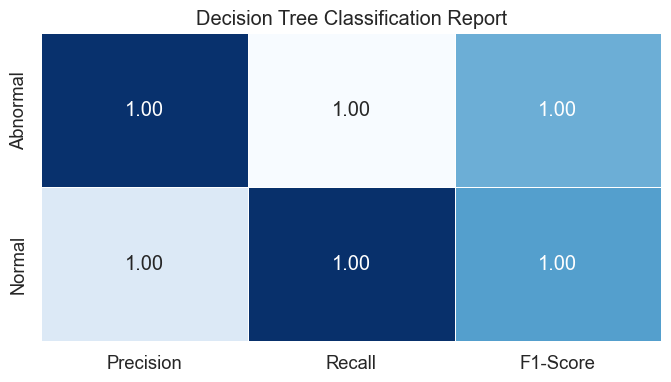

In [47]:
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

precision_rep = [classification_rep['Class 0']['precision'], classification_rep['Class 1']['precision']]
recall_rep = [classification_rep['Class 0']['recall'], classification_rep['Class 1']['recall']]
f1_score_rep = [classification_rep['Class 0']['f1-score'], classification_rep['Class 1']['f1-score']]

report_data = {
    'Precision': precision_rep,
    'Recall': recall_rep,
    'F1-Score': f1_score_rep,
}

class_names = ['Abnormal', 'Normal']

report_df = pd.DataFrame(report_data, index=class_names)

# Plot the classification report
plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap='Blues', cbar=False, linewidths=0.5)
plt.title(f'{model_name} Classification Report')
plt.show()

# Compare the Test Accuracies for each algorithm (Bar Chart)

Comparing various models is beneficial to maintain better generalization by understanding which model is fitting more into the current data. Additionally, it is important to note that, all evaluation metrics are compared in 1 graph.

In [48]:
print(xgb_accuracy)
print(Lr_accuracy)
print(Knn_accuracy)
print(Rf_accuracy)
print(Gnb_accuracy)
print(Dt_accuracy)

99.35960346964065
53.479553903345725
94.7003717472119
99.98859975216853
89.2629491945477
99.90532837670384


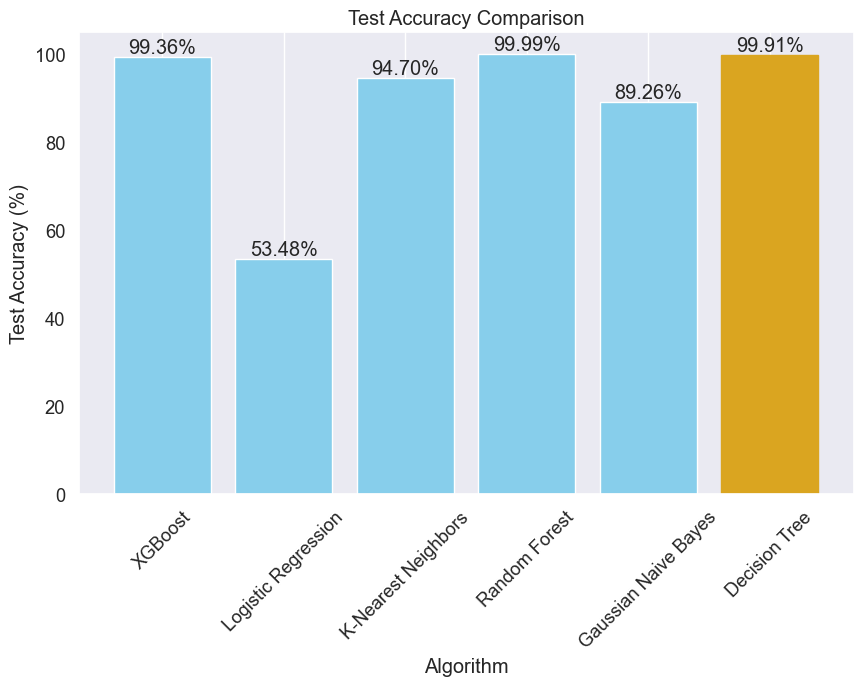

In [49]:
# Define range of training set sizes for learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Test accuracies for each algorithm
test_accuracies = {
    'XGBoost': xgb_accuracy,
    'Logistic Regression': Lr_accuracy,
    'K-Nearest Neighbors': Knn_accuracy,
    'Random Forest': Rf_accuracy,
    'Gaussian Naive Bayes': Gnb_accuracy,
    'Decision Tree': Dt_accuracy
}

# Convert test accuracies to percentages
test_accuracies_percent = {alg: acc for alg, acc in test_accuracies.items()}
for alg, acc in test_accuracies.items():
    test_accuracies_percent[alg] = acc

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(test_accuracies_percent.keys(), test_accuracies_percent.values(), color='skyblue')

# Change the color of the Decision Tree bar to golden
bars[-1].set_color('goldenrod')

plt.xlabel('Algorithm')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add text labels to each bar
for alg, acc in test_accuracies_percent.items():
    plt.text(alg, acc, f'{acc:.2f}%', ha='center', va='bottom')

plt.show()

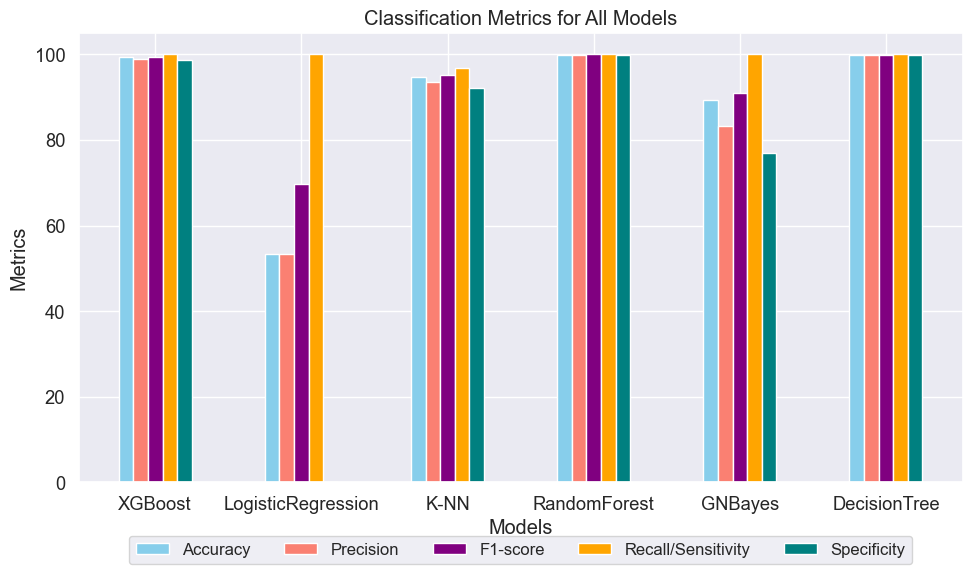

In [50]:
# Sample classification metrics for three models
models = ['XGBoost', 'LogisticRegression', 'K-NN', 'RandomForest', 'GNBayes', 'DecisionTree']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all metrics for each model
width = 0.1
x = np.arange(len(models))
ax.bar(x - 2*width, model_accuracy, width, label='Accuracy', color='skyblue')
ax.bar(x - width, model_precision, width, label='Precision', color='salmon')
ax.bar(x, model_f1_score, width, label='F1-score', color='purple')  # No Offset for F1-score
ax.bar(x + width, model_sensitivity, width, label='Recall/Sensitivity', color='orange')
ax.bar(x + 2*width, model_specificity, width, label='Specificity', color='teal')

# Set labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Classification Metrics for All Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize='small')

# Show plot
plt.tight_layout()
plt.show()

# Deep Learning

Deep Learning is a great technology in AI and that can gives better accuracy due to the complex dataset the system holds with time-series data. Also, it is always nice to compare as much as possible between different methods and ai techniques. 

In [51]:
# Load the binary numpy file
X_train_reshaped = np.load('SplitDatasets/Reshaped/X_train_reshaped.npy')
X_val_reshaped = np.load('SplitDatasets/Reshaped/X_val_reshaped.npy')
X_test_reshaped = np.load('SplitDatasets/Reshaped/X_test_reshaped.npy')


Loaded model from disk
Training Accuracy :  89.19599899545311
Validation Accuracy :  89.1910780669145
6305/6305 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9910 - loss: 0.0346
Testing Accuracy: 0.990914523601532


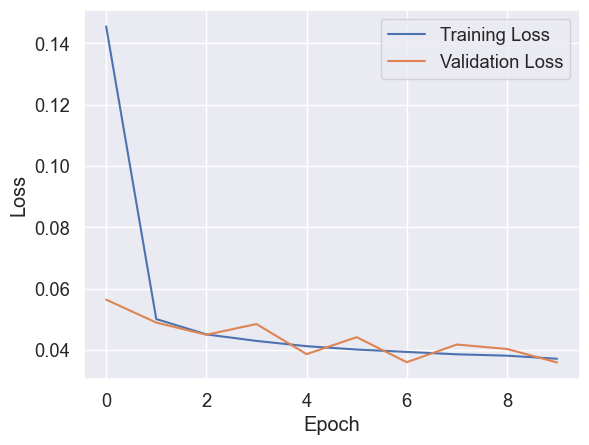

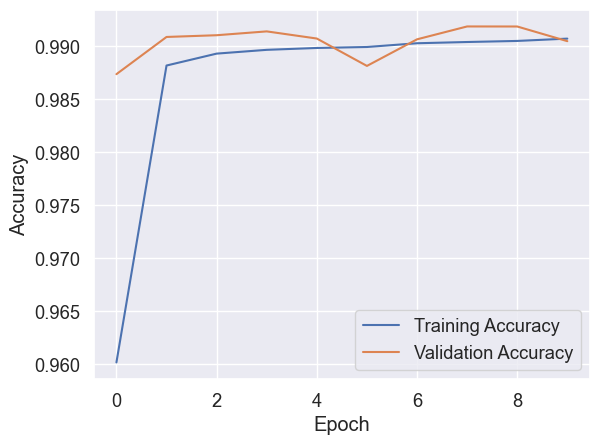

In [52]:
from tensorflow.keras.models import model_from_json
import tensorflow as tf
import json
from keras.models import load_model

json_file = open('TrainingDumpData/DeepLearning/gru_model_architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
GRU_Model = model_from_json(loaded_model_json)

# load weights into new model
GRU_Model.load_weights("TrainingDumpData/DeepLearning/gru_model.weights.h5")
print("Loaded model from disk")

GRU_Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model
print('Training Accuracy : ',
      metrics.accuracy_score(y_train, 
                             gnb.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             gnb.predict(X_val))*100)
test_loss, test_accuracy = GRU_Model.evaluate(X_test_reshaped, y_test)
print("Testing Accuracy:", test_accuracy)

# Load the training history from JSON file
with open('TrainingDumpData/DeepLearning/history.json', 'r') as json_file:
    history_data = json.load(json_file)

# Plot training and validation loss
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy with test accuracy as a horizontal line
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
# Make predictions on the test data
y_pred_probs = GRU_Model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int)

6305/6305 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


In [54]:
model_evaluator = ModelEvaluator(y_test, y_pred)
accuracy, precision, recall, f1_score, sensitivity ,specificity = model_evaluator.evaluate_model()
conf_matrix = model_evaluator.get_confusion_matrix()

# Append results to lists
model_accuracy = np.append(model_accuracy, accuracy) 
model_precision = np.append(model_precision, precision)
model_recall = np.append(model_recall, recall)
model_f1_score = np.append(model_f1_score, f1_score)
model_specificity = np.append(model_specificity, specificity)
model_sensitivity = np.append(model_sensitivity, sensitivity)


Accuracy: 99.09144981412639
Precision: 98.38506596594952
Recall: 99.94160989851244
F1-score: 99.15722975489317
Sensitivity Rate: 99.94160989851244
Specificity Rate: 98.11411219434234


In [72]:
# Print classification report of Deep Learning
print("\nClassification Report of Deep Learning(GRU):")
report = classification_report(y_test, y_pred)
print(report)


Classification Report of Deep Learning(GRU):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     93855
           1       0.98      1.00      0.99    107895

    accuracy                           0.99    201750
   macro avg       0.99      0.99      0.99    201750
weighted avg       0.99      0.99      0.99    201750



Classification Report:
{'Class 0': {'precision': 0.9993163172288059, 'recall': 0.9811411219434234, 'f1-score': 0.9901453202367705, 'support': 93855}, 'Class 1': {'precision': 0.9838506596594953, 'recall': 0.9994160989851244, 'f1-score': 0.9915722975489317, 'support': 107895}, 'accuracy': 0.990914498141264, 'macro avg': {'precision': 0.9915834884441506, 'recall': 0.9902786104642739, 'f1-score': 0.9908588088928512, 'support': 201750}, 'weighted avg': {'precision': 0.9910453525525195, 'recall': 0.990914498141264, 'f1-score': 0.9909084613376162, 'support': 201750}}


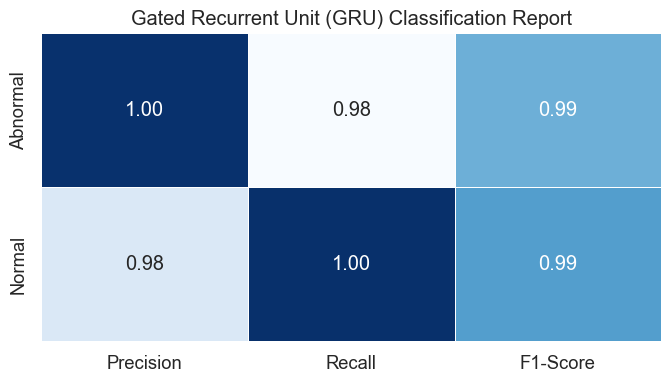

In [56]:


# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

dl_precision = [report['Class 0']['precision'], report['Class 1']['precision']]
dl_recall = [report['Class 0']['recall'], report['Class 1']['recall']]
dl_f1_score = [report['Class 0']['f1-score'], report['Class 1']['f1-score']]

# Print the classification report
print("Classification Report:")
print(report)


dl_report_data = {
    'Precision': dl_precision,
    'Recall': dl_recall,
    'F1-Score': dl_f1_score,
}

class_names = ['Abnormal', 'Normal']

dl_report_df = pd.DataFrame(dl_report_data, index=class_names)

# Plot the classification report
plt.figure(figsize=(8, 4))
sns.heatmap(dl_report_df, annot=True, fmt=".2f", cmap='Blues', cbar=False, linewidths=0.5)
plt.title('Gated Recurrent Unit (GRU) Classification Report')
plt.show()

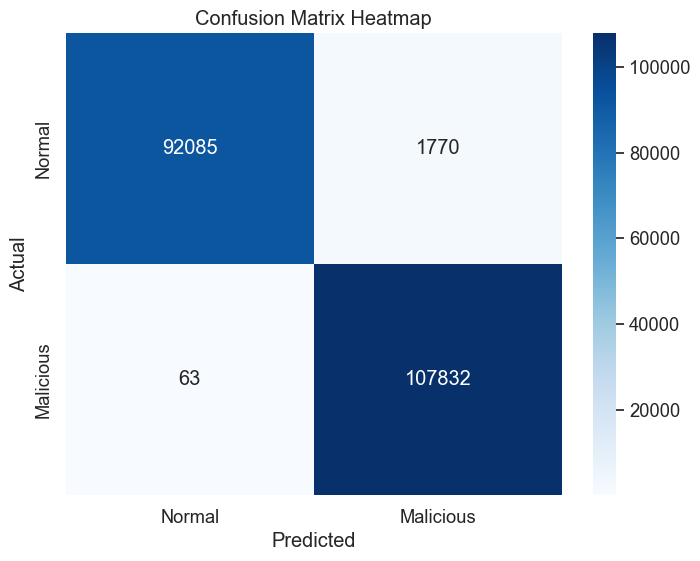

In [57]:
# Assuming y_test and y_pred are true labels and predicted labels, respectively
GRU_conf_matrix = conf_matrix

# Define labels for confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(GRU_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Malicious'], yticklabels=['Normal', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [58]:
dl_result = pd.DataFrame()

dl_result['Actual Label'] = y_test
dl_result['Predicted Label'] = y_pred

dl_result['Actual Label'] = dl_result['Actual Label'].replace(0, 'Benign')
dl_result['Actual Label'] = dl_result['Actual Label'].replace(1, 'Malicious')

dl_result['Predicted Label'] = dl_result['Predicted Label'].replace(0, 'Benign')
dl_result['Predicted Label'] = dl_result['Predicted Label'].replace(1, 'Malicious')

dl_result.head(20)

,Actual Label,Predicted Label
537566,Malicious,Malicious
282563,Malicious,Malicious
286774,Benign,Benign
908792,Benign,Benign
604546,Malicious,Malicious
290562,Benign,Benign
230835,Malicious,Malicious
973040,Malicious,Malicious
824076,Malicious,Malicious
885323,Benign,Benign
